In [6]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

from sklearn.decomposition import NMF
from einops import rearrange
from surfh.Models import wavelength_mrs
from surfh.Simulation import simulation_data
from matplotlib.widgets import Slider


In [7]:
from surfh.Others import global_variables
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Corrected_slices/ch4c_00001_corrected.fits')
data_cube = hdul[0].data
print(data_cube.shape)


(717, 324)


In [8]:
def plot_cube(cube, wavelength_cube, coords):
    
    if cube.shape[0] != 4:
        idx = np.where(np.sum(cube, axis=(1,2)) != 0)[0]
        nzero_slice = slice(idx[0], idx[-1])
        print(nzero_slice)
        cube = cube[nzero_slice, ...]
        wavelength_cube = wavelength_cube[nzero_slice]

    # Initial lambda index
    initial_lambda = 0
    nLambda = cube.shape[0]

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.1, bottom=0.25)  # Adjust the subplot to make space for the slider

    # Display the initial slice
    slice_plot = ax.imshow(cube[initial_lambda, :, :], cmap='viridis')
    ax.set_title(f'Lambda slice: {initial_lambda}')
    ax.plot(coords[0][0],coords[0][1],'.')
    ax.plot(coords[1][0],coords[1][1],'.')
    ax.plot(coords[2][0],coords[2][1],'.')
    ax.plot(coords[3][0],coords[3][1],'.')    
    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax)

    # Create the slider axis and slider
    ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Lambda', 0, nLambda - 1, valinit=initial_lambda, valstep=1)

    # Update function to be called when the slider is changed
    def update(val):
        lambda_index = int(slider.val)
        # Update the image data
        new_slice = cube[lambda_index, :, :]
        slice_plot.set_data(new_slice)
        
        # Update the color limits for the current slice
        slice_plot.set_clim(vmin=np.min(new_slice), vmax=np.max(new_slice))

        # Redraw the colorbar with the new limits
        cbar.update_normal(slice_plot)

        # Update the title to show the current lambda slice
        ax.set_title(f'Lambda slice: {wavelength_cube[lambda_index]}')
        
        # Redraw the figure canvas
        fig.canvas.draw_idle()

    # Attach the update function to the slider
    slider.on_changed(update)

    plt.show()

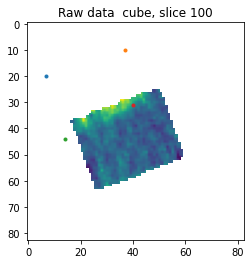

slice(0, 10385, None)


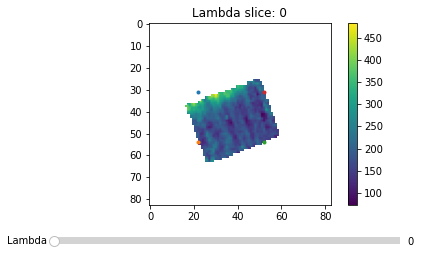

slice(0, 10385, None)


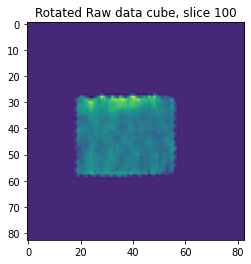

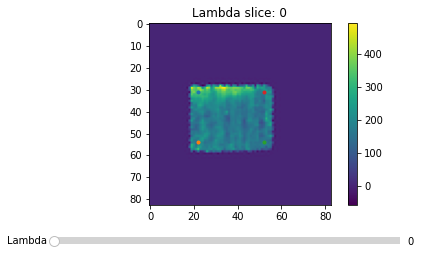

(83, 83)
slice(0, 10385, None)


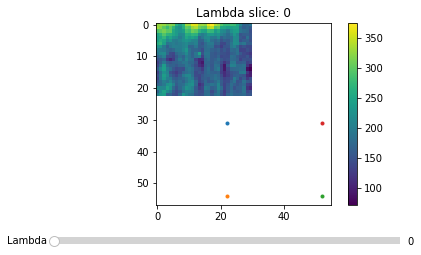

! (10386, 23, 30)
(0,)
(0,)


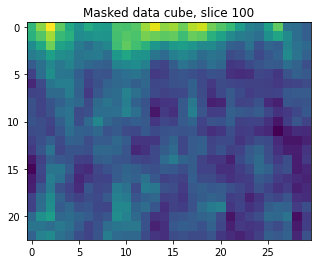

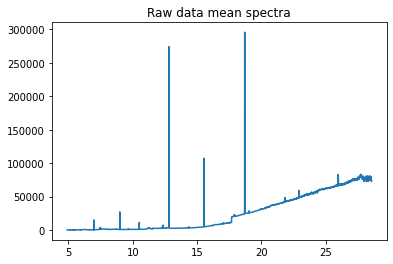

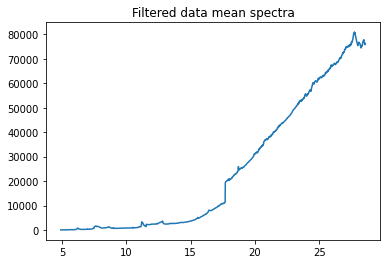

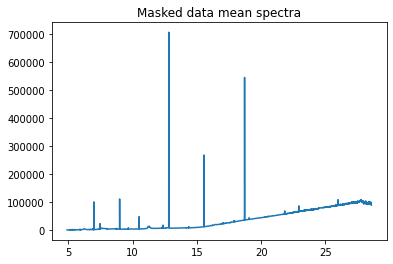

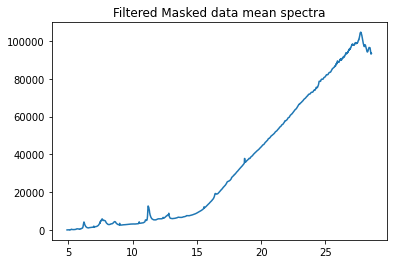

In [9]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-3-4-shortmediumlong_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
cst_data = hdul[1].data
hdr = hdul[1].header
wavel = np.array(hdul[5].data[0])[0,:,0]

wavel = wavel[:-10]
data_cube = data_cube[:-10,:,:]
raw_data_cube = raw_data_cube[:-10,:,:]


from skimage.draw import polygon
def mask_polygon(array, coords):
    """
    Retain values within a polygon defined by coordinates and set other values to 0.

    Parameters:
    - array (2D numpy array): The input array
    - coords (list of tuples): List of 4 (x, y) tuples representing the polygon vertices

    Returns:
    - masked_array (2D numpy array): Array with values inside polygon retained, others set to 0
    """
    # Separate x and y coordinates
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    
    # Create a mask for the polygon area
    mask = np.zeros(array.shape[1:], dtype=bool)
    print(mask.shape)
    rr, cc = polygon(y_coords, x_coords, array.shape)
    mask[rr, cc] = True
    
    # Apply the mask to retain values within the polygon, set others to 0
    masked_array = np.where(mask[np.newaxis,...], array, 0)
    
    return masked_array

plt.figure()
plt.title("Raw data  cube, slice 100")
plt.imshow(raw_data_cube[100])
plt.plot(7,20,'.')
plt.plot(37,10,'.')
plt.plot(14,44,'.')
plt.plot(40,31,'.')
plt.show()

coords = [(22,31), (22,54), (52,54), (52,31)]
plot_cube(raw_data_cube, wavel, coords)


from scipy.ndimage import rotate

angle = -20  # angle en degrés

# Créer un nouveau cube pour stocker les résultats
rotated_cube = np.empty_like(raw_data_cube)
raw_data_cube[np.isnan(raw_data_cube)] = 0
# Appliquer la rotation pour chaque tranche spectrale
for i in range(raw_data_cube.shape[0]):
    # Appliquer la rotation en 2D en gardant le centre de la tranche comme centre de rotation
    rotated_cube[i] = rotate(raw_data_cube[i], angle=angle, reshape=False, axes=(1, 0), order=3, mode='nearest')



plt.figure()
plt.title("Rotated Raw data cube, slice 100")
plt.imshow(rotated_cube[100])
plot_cube(rotated_cube, wavel, coords)



masked_array = mask_polygon(rotated_cube, coords)
masked_array = rotated_cube[:, coords[0][1]:coords[2][1], coords[0][0]:coords[3][0]]
plot_cube(masked_array, wavel, coords)

print("!",masked_array.shape)
plt.figure()
plt.title("Masked data cube, slice 100")
plt.imshow(masked_array[100])


nan_idx = np.where(np.isnan(data_cube))
print(nan_idx[0].shape)
# replace Nan with 0
data_cube[np.isnan(data_cube)] = 0
fitlered_data_cube = ndimage.median_filter(data_cube.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
fitlered_data = rearrange(fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.title("Raw data mean spectra")
plt.plot(wavel, np.mean(data_cube, axis=(1,2)))
plt.figure()
plt.title("Filtered data mean spectra")
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)))


nan_idx = np.where(np.isnan(masked_array))
print(nan_idx[0].shape)
# replace Nan with 0
masked_array[np.isnan(masked_array)] = 0
masked_array_fitlered_data_cube = ndimage.median_filter(masked_array.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
masked_array_fitlered_data = rearrange(masked_array_fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.title("Masked data mean spectra")
plt.plot(wavel, np.nanmean(masked_array, axis=(1,2)))
plt.figure()
plt.title("Filtered Masked data mean spectra")
plt.plot(wavel, np.nanmean(masked_array_fitlered_data_cube, axis=(1,2)))



In [10]:
with fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Filtered_ChannelCube_ch1-2-3-4-shortmediumlong_s3d.fits', mode='update') as hdul1:
    # Change something in hdul.
    test_data = cst_data
    test_data[np.isnan(test_data)] = 0
    f_test_data = ndimage.median_filter(test_data.copy(), size=15, axes=[0])
    f_test_data[f_test_data == 0] = np.nan
    hdul1[1].data = f_test_data
    
    hdul1.flush()  # changes are written back to original.fits


slice(0, 10385, None)


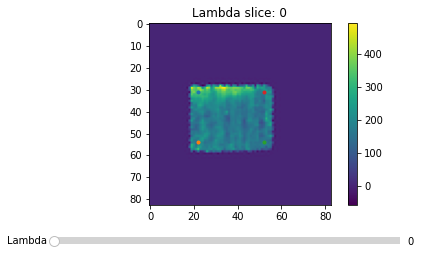

slice(0, 10385, None)


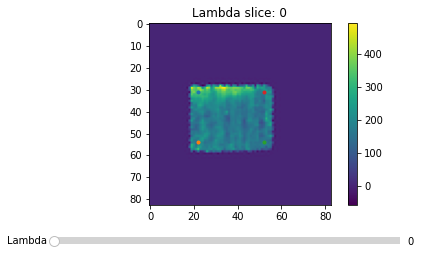

slice(0, 10385, None)


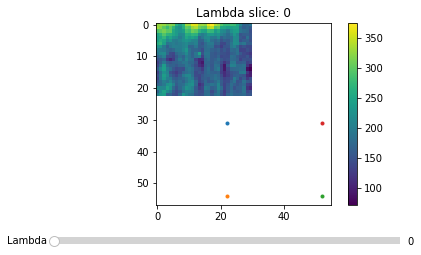

slice(0, 10385, None)


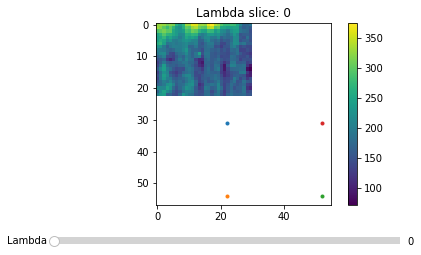

slice(0, 10385, None)


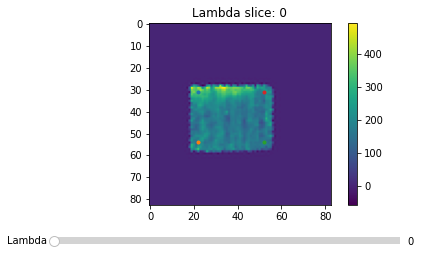

In [4]:
plot_cube(rotated_cube, wavel, coords)
plot_cube(rotated_cube, wavel, coords)
plot_cube(masked_array, wavel, coords)

plot_cube(masked_array, wavel, coords)

plot_cube(rotated_cube, wavel, coords)


/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number 

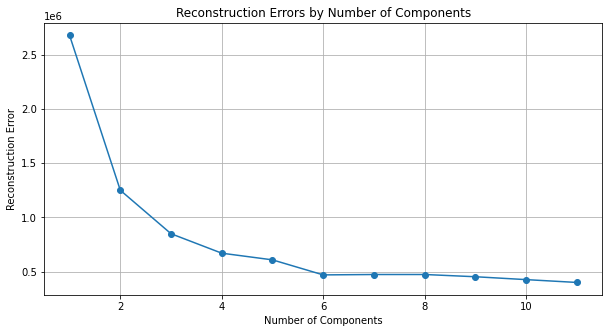

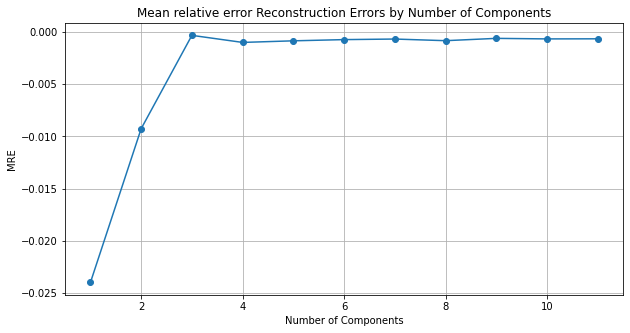

In [5]:
# Range of components to test
component_range = range(1, 12)  # Adjust based on how many tests you want to run

# List to store the reconstruction errors
reconstruction_errors = []
mre_reconstruction_errors = []

# Compute NMF for different numbers of components and calculate the reconstruction errors
for n_components in component_range:
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(masked_array_fitlered_data)  # W is the weight matrix
    H = nmf.components_          # H is the feature matrix (components)
    reconstructed = W @ H        # Reconstruct the original matrix
    error = np.linalg.norm(masked_array_fitlered_data - reconstructed)  # Frobenius norm
    mre_error = np.mean(np.divide((masked_array_fitlered_data-reconstructed), masked_array_fitlered_data, out=np.zeros_like(masked_array_fitlered_data), where=masked_array_fitlered_data!=0))

    reconstruction_errors.append(error)
    mre_reconstruction_errors.append(mre_error)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, mre_reconstruction_errors, marker='o')
plt.title('Mean relative error Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MRE')
plt.grid(True)

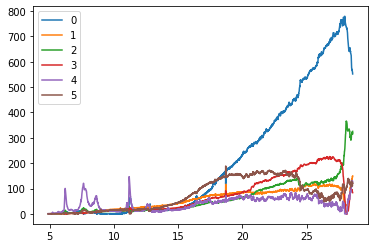

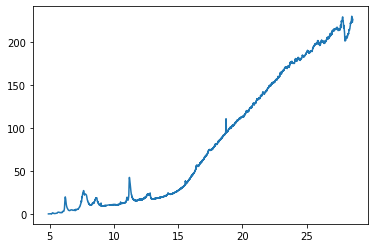

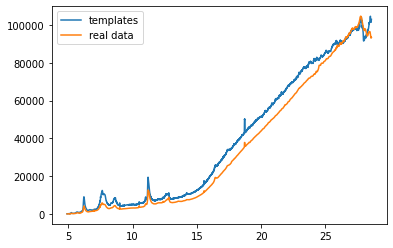

In [6]:
from sklearn.decomposition import NMF

# Initialize NMF with the desired number of components
nmf = NMF(n_components=6, init='random', random_state=0, max_iter=1000)

# Fit NMF model to your data
nmf.fit(masked_array_fitlered_data)

# Extract the components (eigenvectors)
components = nmf.components_

plt.figure()
for i in range(components.shape[0]):
    plt.plot(wavel, components[i], label=i)
plt.legend()
 
plt.figure()
plt.plot(wavel, np.mean(components, axis=0))

masked_array_fitlered_data_cube[masked_array_fitlered_data_cube==0] = np.nan
masked_array[masked_array==0] = np.nan

plt.figure()
scale_f = np.max(np.mean(masked_array_fitlered_data_cube, axis=(1,2)))/np.max(np.mean(components, axis=0))
#scale_f = np.mean(fitlered_data_cube, axis=(1,2))[-1]/np.mean(components, axis=0)[-1]

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.legend()


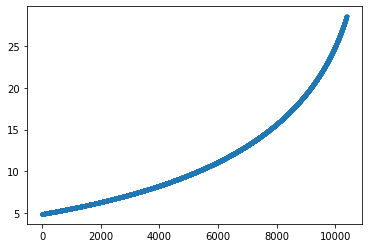

In [7]:
plt.plot(wavel, '.')

[40 44 48 52 56 60 64 68 72 76]
(4, 2596)
Min wavel = 4.900000095367432; Max wavel = 28.581064224243164
Min wavel_axis = -75.59342302777081; Max wavel_axis = 11.543267865039866


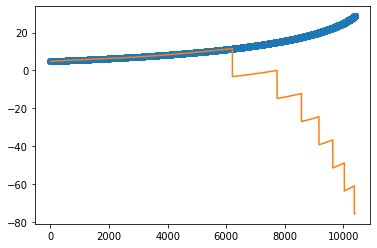

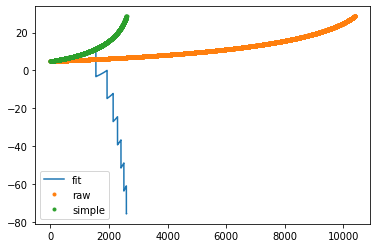

In [13]:
from scipy.optimize import curve_fit

def second_order_function(x, A, B, C):
    return A + B*x**2 + C*x

def third_order_function(x, A, B, C, D):
    return A + D*x**3 + B*x**2 + C*x

def quad_order_function(x, A, B, C, D, E):
    return E*x**4 + D*x**3 + C*x**2 + B*x + A

def five_order_function(x, A, B, C, D, E, F):
    return F*x**5 + E*x**4 + D*x**3 + C*x**2 + B*x + A


def exponential(x, A, B, C):
    return A + B*np.exp(C*x)

def cos_func(x, D, E, A):
    y = A + D*np.cos(E*x)
    return y


xdata = np.arange(len(wavel))
ydata = wavel
parameters, covariance = curve_fit(five_order_function, xdata, ydata)
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
fit_D = parameters[3]
fit_E = parameters[4]
fit_F = parameters[5]


fit_cosine = five_order_function(xdata, fit_A, fit_B, fit_C, fit_D,fit_E, fit_F)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')


def downsample_interpolation(vector, target_size):
    x_old = np.linspace(0, 1, len(vector))
    x_new = np.linspace(0, 1, target_size)
    return np.interp(x_new, x_old, vector)

#wavel_axis = np.linspace(wavel.min(), wavel.max(), len(wavel)-1)

test = downsample_interpolation(np.arange(len(wavel)), len(wavel)//4)
print((test[10:20].astype(int)))
subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = five_order_function(test.astype(int), fit_A, fit_B, fit_C, fit_D,fit_E, fit_F)

wavel_axis = five_order_function(test.astype(int), fit_A, fit_B, fit_C, fit_D,fit_E, fit_F)
plt.figure()
plt.plot(wavel_axis, '-', label='fit')
plt.plot(wavel, '.', label='raw')
plt.plot(wavel[::4], '.', label='simple')
plt.legend()

subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = np.interp(wavel_axis, wavel, components[i])


print(subsampled_interpn.shape)
print(f'Min wavel = {np.min(wavel)}; Max wavel = {np.max(wavel)}')
print(f'Min wavel_axis = {np.min(wavel_axis)}; Max wavel_axis = {np.max(wavel_axis)}')

Shape wevel = (10386,), (2597,)


Text(0.5, 1.0, 'Mean compenents')

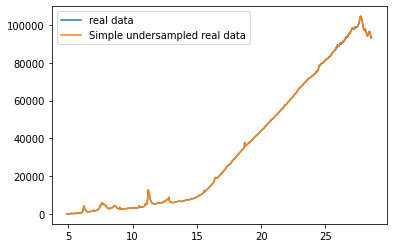

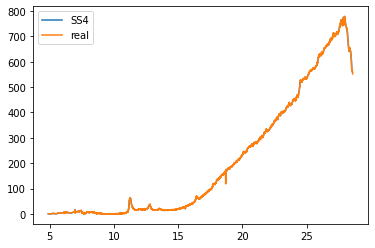

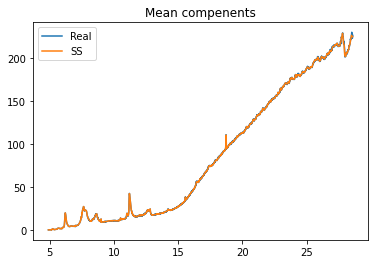

In [7]:
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.plot(wavel[::4], np.mean(masked_array_fitlered_data_cube[::4], axis=(1,2)), label='Simple undersampled real data')
plt.legend()
print(f"Shape wevel = {wavel.shape}, {wavel[::4].shape}")


SS_wavel = wavel[::4]
subsampled_interpn = np.zeros((components.shape[0], len(SS_wavel)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = components[i,::4]

plt.figure()
plt.plot(SS_wavel, subsampled_interpn[0], label='SS4')
plt.plot(wavel, components[0], label='real')
plt.legend()


plt.figure()
plt.plot(wavel, np.mean(components, axis=0), label="Real")
plt.plot(SS_wavel, np.mean(subsampled_interpn, axis=0), label='SS')
plt.legend()
plt.title("Mean compenents")


In [23]:
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/nmf_orion_1ABC_2ABC_3ABC_4ABC_6_templates_SS4.npy', subsampled_interpn)
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/wavel_axis_orion_1ABC_2ABC_3ABC_4ABC_6_templates_SS4.npy', SS_wavel)
